Testing processes (see below, in order) on new images provided by Rachel to check performance in different enviornments than what was trained on.

(1) Image Segmentation (current method: watershed)
(2) Image Measurement (Current: skimage.measure
(3) Model Classification (current: Random Forest [i] C & MC vs I & P, [ii] C vs MC

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.stats as stat
import numpy as np 
#import forestsci
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections import Counter
import pickle
import glob

import sys
sys.path.append("..")
from Utility.segmentation_utils import * 

image_folder = "../Images/Additional" # Path to folder, adjust for other machines
image_list_Si = glob.glob(f'{image_folder}/Si embed/*')
image_list_Yuanwei = glob.glob(f'{image_folder}/Images to rachel (from Yuanwei)/*/*') # Might want to separate this?



Image Segmenter on 2_01 created!


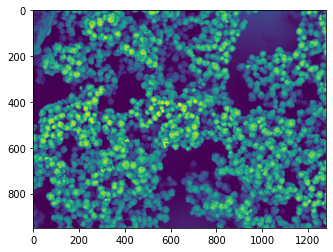

In [4]:
IS = ImageSegmenter(image_list_Si[3])
plt.imshow(IS.img2)

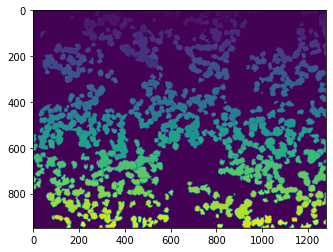

In [5]:
import matplotlib.pyplot as plt
plt.imshow(IS.markers)

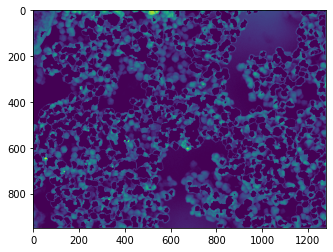

In [6]:
# Quick check so one can see what region was "forgotten" by image segmenter
img_forgotten = copy.deepcopy(IS.img2)
img_forgotten[IS.markers > 10] = 0
plt.imshow(img_forgotten)

In [12]:
# load first RF model from disk
model_name = "../Models/RF_C-MC_I-P.sav"
loaded_model = pickle.load(open(model_name, 'rb'))
loaded_model

/home/jacob/anaconda3/envs/colloidal_crystal/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jacob/anaconda3/envs/colloidal_crystal/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


RandomForestRegressor(oob_score=True)

In [9]:
# Prepare data
features=['area',
#        'equivalent_diameter', 
#        'orientation', 
    'major_axis_length',
    'minor_axis_length',
    'perimeter',
        'min_intensity',
        'mean_intensity',
        'max_intensity',
    'solidity',
    'major_axis_length/minor_axis_length',
    'perimeter/major_axis_length',
    'perimeter/minor_axis_length',
          'feret_diameter_max',
      'moments_hu-0',
      'moments_hu-1',
      'moments_hu-2',
#      'moments_hu-3',
#      'moments_hu-4',
#      'moments_hu-5',
#      'moments_hu-6',
#    'eccentricity'
         ]

df = IS.df
#print(np.unique(df["Filename"]))

# Modify Data (Remove illegal data OR set different runtime)

# Numerical errors (divide by 0)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
for feature in features:
    df.dropna(subset=[feature],inplace=True)

# Split Data (TO-DO)
X=df[features]

# Make adjustments to data
X=X # For RF, feature normalization NOT NEEDED

# NOTE (2022.08.24): What do I have to do with the classification afterwards???

#y
#ohe = OneHotEncoder(sparse=False)
#y = ohe.fit_transform(df[[label]])

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

/home/jacob/Desktop/Wolverton/2022/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:164: RuntimeWarning: divide by zero encountered in divide
  clusters['major_axis_length/minor_axis_length'] = clusters['major_axis_length']/clusters['minor_axis_length']
/home/jacob/Desktop/Wolverton/2022/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:166: RuntimeWarning: invalid value encountered in divide
  clusters['perimeter/minor_axis_length'] = clusters['perimeter']/clusters['minor_axis_length']


In [10]:
predicted_data = loaded_model.predict(X)

def assign_label(predicted_data):
    '''
    Given an array of arrays, get the max column, associate that with a name, and return the fully labeled list
    '''
    label_arr = []
    for data in predicted_data:
        index = np.argmax(data)
        if index == 0:
            label_arr.append("Crystal")
        if index == 1:
            label_arr.append("Incomplete")
    return label_arr
        
labeled_arr = assign_label(predicted_data)
IS.df['Labels'] = labeled_arr
IS.override_exists=True
IS.create_csv()
print(IS._csv_file)

../Results/values_2_01.csv


In [11]:
df_Crystal = IS.df[IS.df["Labels"] == "Crystal"]
df_Incomplete = IS.df[IS.df["Labels"] != "Crystal"]
print(f'Num Crystals: {len(df_Crystal)} \nNum Incomplete: {len(df_Incomplete)}')

Num Crystals: 247 
Num Incomplete: 183


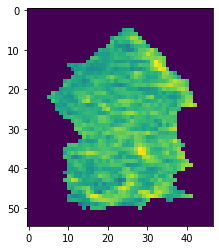

Model Thinks: Incomplete


In [ ]:

for ii in np.arange(len(IS.region_arr)):
    clear_output(wait=False)
    plt.imshow(IS.region_arr[ii])
    plt.show()
    print(f'Model Thinks: {labeled_arr[ii]}')
    input('Next (hit enter)')
